# Nissen et al., 2023: Severe 21st-century OA in Antarctic MPAs
#
# Fig. 4 & Fig. S6: vertical profiles of oxygen in MPAs

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from matplotlib import cm
from netCDF4 import Dataset, MFDataset
import pandas as pd
from matplotlib.patches import Rectangle
from numba import njit

In [2]:
#------
# MODEL INFO
#------

# path to carbonate chemistry data (full model fields)
path_to_data = '/pscratch/sd/c/cnissen/COARZE_oxy/' # code expects separate folders for hist, ssp585 etc.

# path to masks of MPAs (on original FESOM mesh)
path_to_mask = '/pscratch/sd/c/cnissen/HLRN_runs_postprocessed/masks/masks_MPAs/'

savepath    = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_Vertical_profiles/oxygen/'
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)

savepath2    = '/global/cfs/cdirs/m4003/cnissen/Plots/Paper_OA_in_MPAs/Fig_Vertical_profiles/oxygen/eps/'
if not os.path.exists(savepath2):
    print('Created '+savepath2)
    os.makedirs(savepath2)
    
#---
# load mesh info
#---

path_mesh = '/pscratch/sd/c/cnissen/'
file_mesh = 'Nissen2022_FESOM_REcoM_mesh_information_corrected_20220910.nc'

f1 = Dataset(path_mesh+file_mesh) #xr.open_dataset(path+file1)
lat_model      = f1.variables['lat'][:]
lon_model      = f1.variables['lon'][:]
zlevs    = f1.variables['zlevs'][:]
cavities = f1.variables['cavity'][:]
topo     = f1.variables['topo'][:]
area     = f1.variables['cell_area'][:]
volume   = f1.variables['cell_volume'][:]
f1.close()
print(lat_model.shape)

ind_no_cavity = np.where(cavities==0)[0]
ind_cavities = np.where(cavities==1)[0]


(72411,)


In [3]:
#-------
# get subregions
#-------

#----
# get masks for MPAs (on original FEOSM mesh)
#----

f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
mask_WAP_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
mask_Orkney_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
mask_RossSea_MPA = f1.variables['mask_fesom'][:]
f1.close()
f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
f1.close()


In [4]:
#---
# FUNCTION to re-organize original FESOM output in cavities
#---

@njit
def reorganize_field_in_cavities(ind_cavities,data): 
    for ii in ind_cavities: #ind_cavities: 
        bb = data[:,ii] # get all depth levels at current cavity node
        ind_av = np.where(bb>0)[0] # get indices of all depth levels that are NOT masked
        #ind_av = bb>=0 #bb.mask==False
        #nd_av = np.where(ind_av==True)[0]
        #print ind_av
        # if surface value is filled, but thereafter there is a gap: 
        if len(ind_av)>1:
            if (ind_av[1]-ind_av[0])>1:  #any(np.diff(ind_av)>1):  
                bb[ind_av[1]-1]=bb[ind_av[0]] # move "surface" value to correct depth
                bb[ind_av[0]] = 0 # set surface entry to zero
               
        data[:,ii] = bb # overwrite original field
    return data


In [5]:
#-----
# load data for 1990s: oxy
#-----

vari = 'bgc22'

sim_list = ['simAssp585','simAssp370','simAssp245','simAssp126']
which_sim = sim_list[0] # for present-day, choose ssp585 here (this is where historical data area stored in this case)

print_progress = 4000

years = np.arange(1990,1999+1,1)

array_1990s_simA   = np.zeros([len(np.unique(zlevs)),len(lon_model),len(years)]) # only 97 depth levels filled in file
for yy in range(0,len(years)):
    print ('Load '+str(years[yy])+' of '+which_sim)
    
    f1 = Dataset(path_to_data+'hist/'+vari+'_fesom_'+str(years[yy])+'0101.nc')
    data1 = f1.variables[vari][:,:,:].mean(axis=0)
    f1.close()
    array_1990s_simA[:,:,yy]    = data1
    data1[data1.mask==True]=0
    data1 = reorganize_field_in_cavities(ind_cavities,data1) # set "surface" value in cavities to 
    
    del data1
    
# decadal avg
array_1990s_simA    = np.nanmean(array_1990s_simA,axis=2) 
    
print ('done')


Load 1990 of simAssp585
Load 1991 of simAssp585
Load 1992 of simAssp585
Load 1993 of simAssp585
Load 1994 of simAssp585
Load 1995 of simAssp585
Load 1996 of simAssp585
Load 1997 of simAssp585
Load 1998 of simAssp585
Load 1999 of simAssp585
done


In [6]:
#-----
# load data for 2090s: temp
#-----
 
sim_list  = ['simAssp585','simAssp370','simAssp245','simAssp126']
sim_list2 = ['simA-ssp585','simA-ssp370','simA-ssp245','simA-ssp126']

years = np.arange(2090,2099+1,1)

# only 97 depth levels filled in file
array_2090s    = np.zeros([len(np.unique(zlevs)),len(lon_model),len(years),len(sim_list)]) 
for ss in range(0,len(sim_list)):
    
    if sim_list[ss] in ['simAssp585']:
        path = path_to_data+'ssp585/'
    elif sim_list[ss] in ['simAssp370']:
        path = path_to_data+'ssp370/'
    elif sim_list[ss] in ['simAssp245']:
        path = path_to_data+'ssp245/'
    elif sim_list[ss] in ['simAssp126']:
        path = path_to_data+'ssp126/'
    
    for yy in range(0,len(years)):
        print ('Load '+str(years[yy])+' of '+sim_list[ss])

        f1 = Dataset(path+vari+'_fesom_'+str(years[yy])+'0101.nc')
            
        data1 = f1.variables[vari][:,:,:].mean(axis=0)
        f1.close()
        array_2090s[:,:,yy,ss]    = data1
        del data1
    
# decadal avg
array_2090s    = np.nanmean(array_2090s,axis=2)  
    
print ('done')


Load 2090 of simAssp585
Load 2091 of simAssp585
Load 2092 of simAssp585
Load 2093 of simAssp585
Load 2094 of simAssp585
Load 2095 of simAssp585
Load 2096 of simAssp585
Load 2097 of simAssp585
Load 2098 of simAssp585
Load 2099 of simAssp585
Load 2090 of simAssp370
Load 2091 of simAssp370
Load 2092 of simAssp370
Load 2093 of simAssp370
Load 2094 of simAssp370
Load 2095 of simAssp370
Load 2096 of simAssp370
Load 2097 of simAssp370
Load 2098 of simAssp370
Load 2099 of simAssp370
Load 2090 of simAssp245
Load 2091 of simAssp245
Load 2092 of simAssp245
Load 2093 of simAssp245
Load 2094 of simAssp245
Load 2095 of simAssp245
Load 2096 of simAssp245
Load 2097 of simAssp245
Load 2098 of simAssp245
Load 2099 of simAssp245
Load 2090 of simAssp126
Load 2091 of simAssp126
Load 2092 of simAssp126
Load 2093 of simAssp126
Load 2094 of simAssp126
Load 2095 of simAssp126
Load 2096 of simAssp126
Load 2097 of simAssp126
Load 2098 of simAssp126
Load 2099 of simAssp126
done


In [7]:
#---
# FUNCTION
#---

def get_indices_in_region(rr,subregions,path_to_mask):
    
    #----
    # get masks for MPAs
    #----

    f1 = Dataset(path_to_mask+'MPA_mask_AntarcticPeninsula_fesom_mesh_COARZE.nc')
    mask_WAP_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_1_fesom_mesh_COARZE.nc')
    mask_eastAA1_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_2_fesom_mesh_COARZE.nc')
    mask_eastAA2_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_East_Antarctica_3_fesom_mesh_COARZE.nc')
    mask_eastAA3_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_Orkney_fesom_mesh_COARZE.nc')
    mask_Orkney_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_RossSea_fesom_mesh_COARZE.nc')
    mask_RossSea_MPA = f1.variables['mask_fesom'][:]
    f1.close()
    f1 = Dataset(path_to_mask+'MPA_mask_WeddellSea_fesom_mesh_COARZE.nc')
    mask_WeddellSea_MPA = f1.variables['mask_fesom'][:]
    f1.close()

    if subregions[rr] in ['RossSea_MPA']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['RossSea_MPA_shelf']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['RossSea_MPA_openOcean']:
        ind_regions = np.where((mask_RossSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['WeddellSea_MPA_shelf']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['WeddellSea_MPA_openOcean']:
        ind_regions = np.where((mask_WeddellSea_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA_shelf']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['AntarcticPeninsula_MPA_openOcean']:
        ind_regions = np.where((mask_WAP_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['Orkney_MPA']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['Orkney_MPA_shelf']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['Orkney_MPA_openOcean']:
        ind_regions = np.where((mask_Orkney_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_1_MPA']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_shelf']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_1_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA1_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_shelf']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_2_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA2_MPA==1) & (cavities==0) & (topo>2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_shelf']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_3_MPA_openOcean']:
        ind_regions = np.where((mask_eastAA3_MPA==1) & (cavities==0) & (topo>2000))[0]
            
    elif subregions[rr] in ['East_Antarctica_all_MPA']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0))[0]
    elif subregions[rr] in ['East_Antarctica_all_MPA_shelf']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo<=2000))[0]
    elif subregions[rr] in ['East_Antarctica_all_MPA_openOcean']:
        ind_regions = np.where(((mask_eastAA1_MPA==1) | (mask_eastAA2_MPA==1) | (mask_eastAA3_MPA==1) ) & (cavities==0) & (topo>2000))[0]
    
    return ind_regions


In [8]:
#---
# plotting function: plot whole MPA and shelf together
#---

def plot_profile_shelf_vs_whole_MPA_save_as_png_or_eps(profile_1990s,profile_2090s,\
                                    profile_1990s_shelf,profile_2090s_shelf,vari,vari_label,subregions,rr,\
                             num_depths,depths,save_plot,display_plots,savepath,format2):
    
    sim_list2 = ['SSP5-8.5','SSP3-7.0','SSP2-4.5','SSP1-2.6']

    ylim1,ylim2 = -2000,0
    lw = 3
    lw2 = 1.5
    fs = 12
    ls1 = '-'
    ls2 = ':'
    alpha1 = 0.3
    color1 = 'black'#'darkblue'
    dpicnt = 150

    #-----
    # NEW COLOR SCHEME
    #-----
    # for now: ssp126 is light grey in all color schemes
    
    cc1 = (52./255.,103./255.,92./255.) # pine
    cc2 = (161./255.,190./255.,149./255.) # sage
    cc3 = (45./255.,66./255.,98./255.) # indigo
    cc4 = (248./255.,160./255.,85./255.) # Canteloupe
    cc5 = (186./255.,168./255.,150./255.) # warm grey

    # Ross: deep aqua, ocean(7,87,91), wave, seafowm
    color_list1 = [(0./255.,59./255.,70./255.),(102./255.,165./255.,173./255.),(196./255.,223./255.,230./255.),\
                  (0.92,0.92,0.92)]
    # eastAA: olive green, sage, honeydew(226, 223, 162), cream(235,220,178), linen(234,226,214), fog
    color_list2 = [(75./255.,116./255.,71./255.),(161./255.,190./255.,149./255.),(201./255.,209./255.,200./255.),\
                  (0.92,0.92,0.92)]
    # Weddell: midnight blue (52, 77, 144)
    color_list3 = [(26./255.,64./255.,95./255.),(51./255.,123./255.,174./255.),(208./255.,225./255.,249./255.),\
                  (0.92,0.92,0.92)]
    # Orkney: red clay(164,56,32), bronze(192,88,5), carrot, desert(186, 85, 54), Canteloupe,  sunglow(217,180,74) (beige/sandstone)
    color_list4 = [(164./255.,56./255.,32./255.),(238./255.,105./255.,36./255.),(248./255.,160./255.,85./255.),\
                  (0.92,0.92,0.92)]
    # WAP: eggplant, pewter(134,118,102), warm grey, putty
    color_list5 = [(80./255.,49./255.,47./255.),(186./255.,168./255.,150./255.),(230./255.,204./255.,181./255.),\
                  (0.92,0.92,0.92)]
    # grey scale for areas that are not MPAs
    color_list6 = [(0./255.,0./255.,0./255.),(75./255.,75./255.,75./255.),(150./255.,150./255.,150./255.),\
                  (0.92,0.92,0.92)]
    
    if subregions[rr] in ['RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean']: # pine
        color_plot = cc1
        color_list = color_list1
    elif subregions[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_shelf','East_Antarctica_all_MPA_openOcean']: # sage
        color_plot = cc2
        color_list = color_list2
    elif subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean']: # indigo
        color_plot = cc3
        color_list = color_list3
    elif subregions[rr] in ['Orkney_MPA']: # blue
        color_plot = cc4
        color_list = color_list4
    elif subregions[rr] in ['AntarcticPeninsula_MPA','AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']: # warm grey
        color_plot = cc5
        color_list = color_list5
    else:
        color_plot = 'k'
        color_list = color_list6
        
    fc_undersat = [250./255., 240./255., 230./255.]  
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,5), dpi=dpicnt,\
                                gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
    plt.subplots_adjust(wspace=0.1)
    plt.subplots_adjust(hspace=0.0) 

    ax = plt.subplot2grid((1,1), (0, 0))#, colspan=2)
    
    #----
    # shelf
    ls = '--'
    ax.plot(profile_1990s_shelf[::-1],-1*depths[::-1],color=color1,linestyle=ls,linewidth=lw2) 
    for ss in range(0,len(sim_list)):
        ax.plot(profile_2090s_shelf[::-1,ss],-1*depths[::-1],\
                color=color_list[ss],linestyle=ls,linewidth=lw2) 
    #-----
    
    ax.plot(profile_1990s[::-1],-1*depths[::-1],color=color1,linewidth=lw,label='1990s') 
    for ss in range(0,len(sim_list)):
        ax.plot(profile_2090s[::-1,ss],-1*depths[::-1],\
                color=color_list[ss],linewidth=lw,label='2090s, '+sim_list2[ss]) 

    #ax.hlines(-700,8,10.5,color='k',linestyle=':',alpha=alpha1) 
    if format2 in ['png']:
        ax.set_ylabel('Depth in m',fontsize=fs)
        ax.set_xlabel(vari_label,fontsize=fs)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylim((ylim1,ylim2))
    if vari in ['OmegaA']:
        ax.set_xlim((0.5,1.5))
        ax.set_xticks([0.5,0.75,1.0,1.25,1.5])
        if format2 in ['png']:
            ax.set_xticklabels([0.5,'',1.0,'',1.5])
        elif format2 in ['eps']:
            ax.set_xticklabels([])
    elif vari in ['OmegaC']:
        ax.set_xlim((0.8,2.5))
        ax.set_xticks([1.0,1.5,2.0,2.5])
        if format2 in ['png']:
            ax.set_xticklabels([1.0,1.5,2.0,2.5])
        elif format2 in ['eps']:
            ax.set_xticklabels([])
    elif vari in ['pH']:
        ax.set_xlim((7.6,8.2))
        ax.set_xticks([7.6,7.8,8.0,8.2])
        if format2 in ['png']:
            ax.set_xticklabels([7.6,7.8,8.0,8.2])
        elif format2 in ['eps']:
            ax.set_xticklabels([])
    elif vari in ['temp','temperature']:
        ax.set_xlim((-1.8,0.7))
        ax.set_xticks([-1.5,-1.0,-0.5,0.0,0.5])
        if format2 in ['png']:
            ax.set_xticklabels([-1.5,-1.0,-0.5,0.0,0.5])
        elif format2 in ['eps']:
            ax.set_xticklabels([])
    elif vari in ['oxygen']:
        ax.set_xlim((150,350))
        ax.set_xticks([150,200,250,300,350])
        if format2 in ['png']:
            ax.set_xticklabels([150,200,250,300,350])
        elif format2 in ['eps']:
            ax.set_xticklabels([])
    ax.set_yticks([0,-500,-1000,-1500,-2000])
    if format2 in ['png']:
        ax.set_yticklabels([0,500,1000,1500,2000])
    elif format2 in ['eps']:
        ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs)
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs)
    # mark lysocline depth
    ind_below1 = np.where(profile_1990s<1)[0]
            
    #ax.arrow(1.0,-2010, -0.25, 0)
    if vari in ['OmegaA']:
        ax.annotate('undersaturation',xy=(0.48,0.016), xycoords='axes fraction',\
                                 ha='right',fontsize=fs-6,color='black',style='italic') # below: x=0.5, y=-0.035
    if format2 in ['png']:
        ax.legend(loc='upper center', bbox_to_anchor=(0.77, 0.22),\
                    ncol=1,fancybox=True, markerfirst=False,frameon=False,shadow=False,prop={'size': 7})

    if save_plot:
        if format2 in ['eps']: 
            savepath2 = savepath+'eps/'
        elif format2 in ['png']: 
            savepath2 =savepath
        plt.savefig(savepath2+'Vertical_profiles_'+vari+'_1990s_vs_2090s_'+subregions[rr]+'_with_shelf.'+format2,\
                                            dpi = dpicnt, bbox_inches='tight',format=format2) 

    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        

RossSea_MPA


/tmp/ipykernel_633410/90977277.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:71: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/90977277.py:77: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


RossSea_MPA_shelf


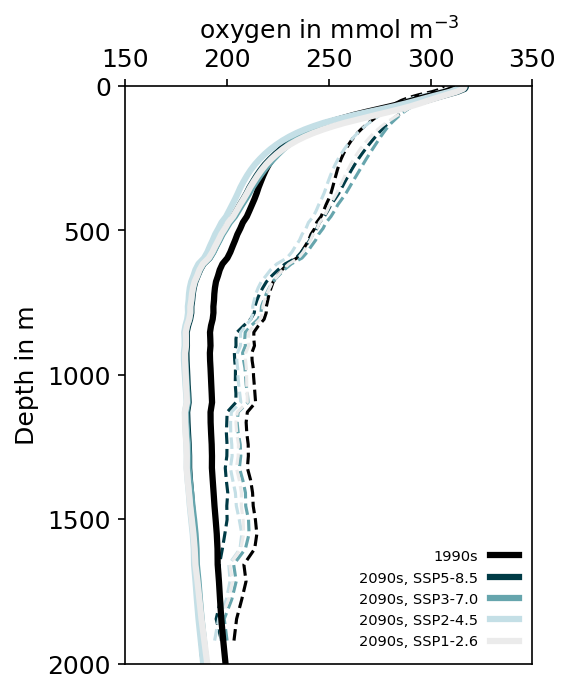

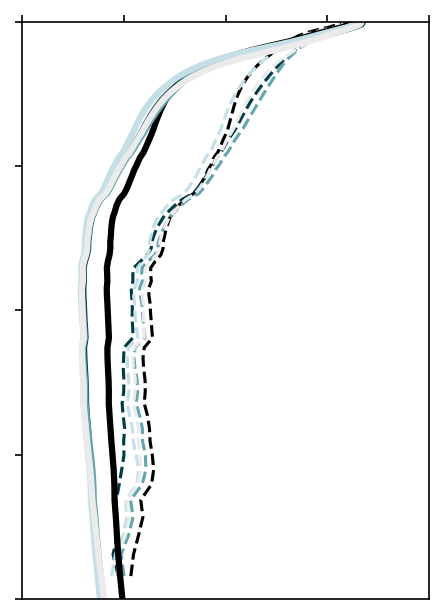

WeddellSea_MPA


/tmp/ipykernel_633410/90977277.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:71: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/90977277.py:77: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


WeddellSea_MPA_shelf


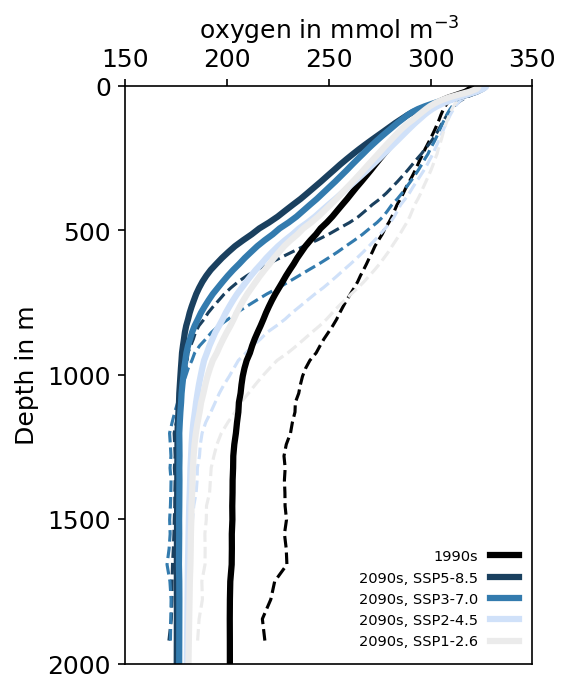

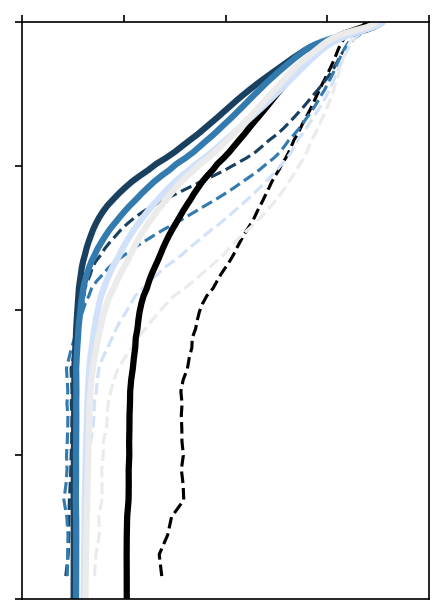

Orkney_MPA


/tmp/ipykernel_633410/90977277.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])


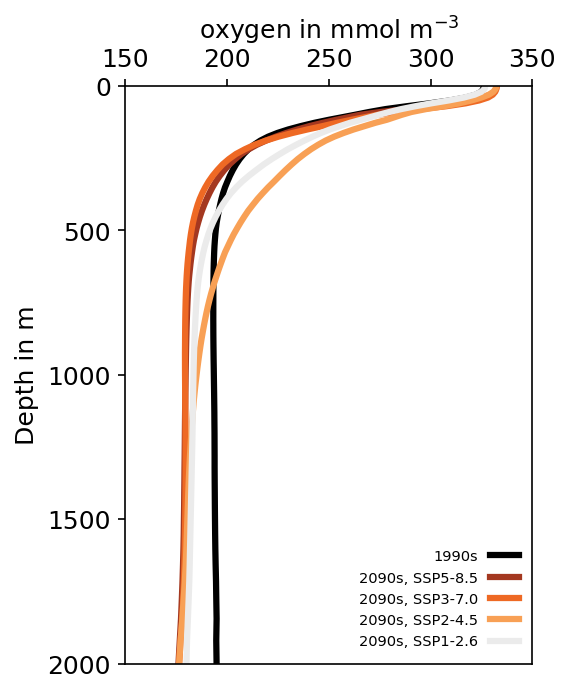

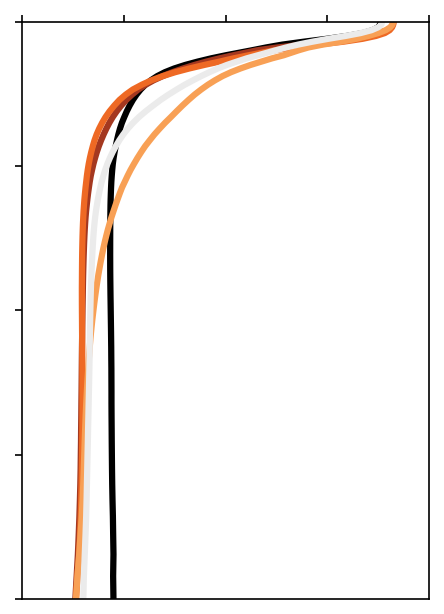

AntarcticPeninsula_MPA


/tmp/ipykernel_633410/90977277.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:71: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/90977277.py:77: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


AntarcticPeninsula_MPA_shelf


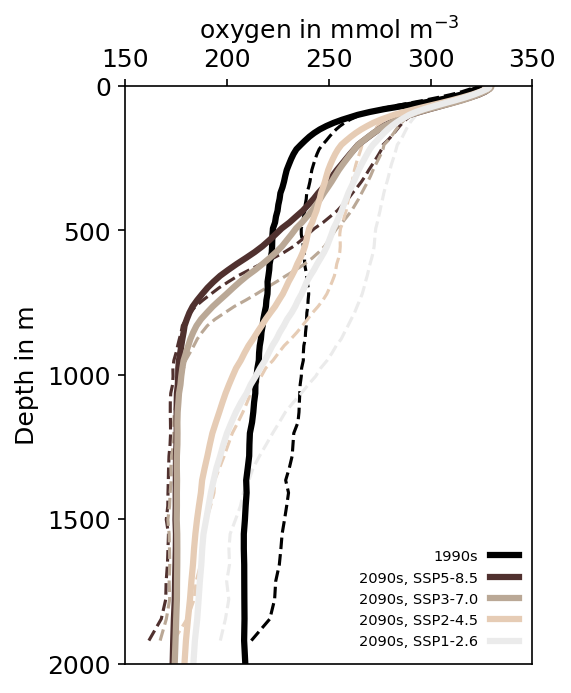

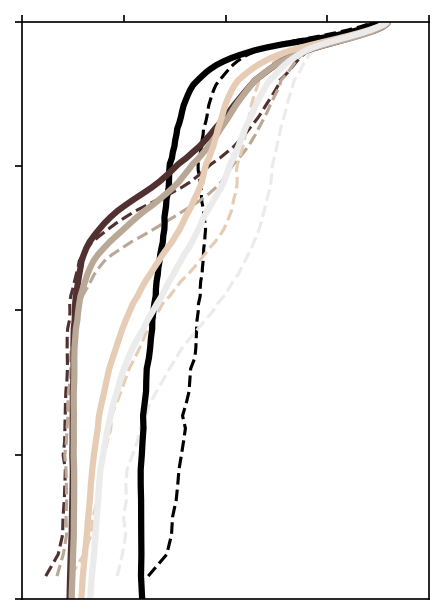

East_Antarctica_all_MPA


/tmp/ipykernel_633410/90977277.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/90977277.py:71: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/90977277.py:77: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


East_Antarctica_all_MPA_shelf


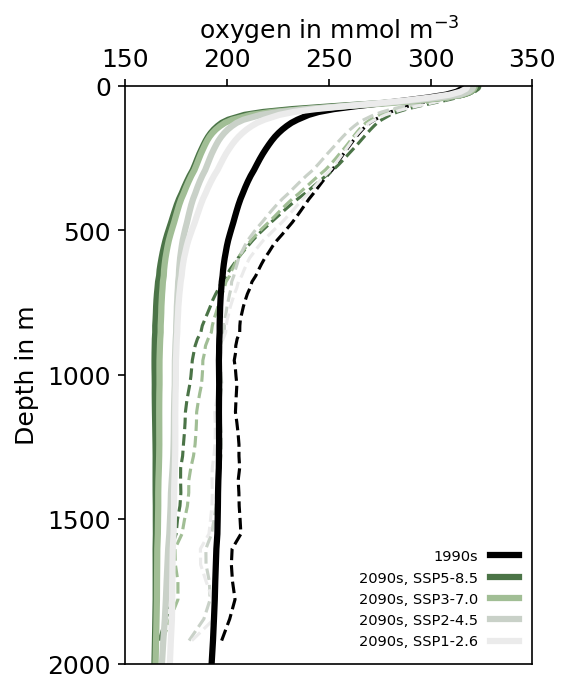

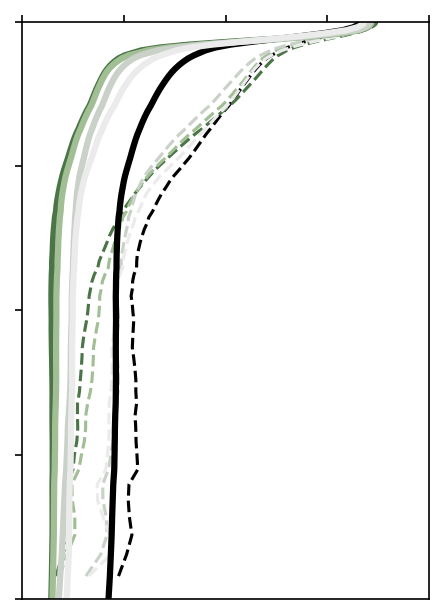

done


In [9]:
#----
# PLOT vertical profile of oxygen
#----

# available subregions (see function 'get_indices_in_region()')
subregions = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
             'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']

save_plot = False
display_plots = True

for rr in [8,11,14,15,19]: # HARD-CODED
    print (subregions[rr])
    
    # get indices of original FESOM mesh that lie in current subregion
    ind1_so = get_indices_in_region(rr,subregions,path_to_mask)

    #-----
    # get avg vertical profiles
    #-----

    data1 = np.copy(array_1990s_simA)
    data2 = np.copy(array_2090s)

    area2 = np.copy(area)
    area2 = np.tile(area2,[data1.shape[0],1])
    
    num_depths = area2.shape[0]
    depths = np.unique(zlevs)#[:-2]

    #------
    # set zeros to NaN
    # make sure to also correct 
    # area field so that the "total area" at each depth level actually corresponds ot the area that is there
    area2[data1==0]=np.nan 
    data1[data1==0]=np.nan
    data2[data2==0]=np.nan
    #------
    
    # pH, 1990s
    profile_so = np.nan*np.zeros([area2.shape[0]])
    for dd in range(0,area2.shape[0]): # loop over depths
        profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])

    # pH, 2090s
    profile_2090s_so = np.nan*np.zeros([area2.shape[0],len(sim_list)])
    for ss in range(0,len(sim_list)):
        for dd in range(0,area2.shape[0]): # loop over depths
            profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])

            
    #-----
    # get corresponding shelf part
    #-----      
    if not subregions[rr] in ['Orkney_MPA']:
        ind_shelf = subregions.index(subregions[rr]+'_shelf')
        print (subregions[ind_shelf])

        # get indices of original FESOM mesh that lie in current subregion
        ind1_so_b = get_indices_in_region(ind_shelf,subregions,path_to_mask)

        # omega arag, 1990s
        profile_so_shelf = np.nan*np.zeros([area2.shape[0]])
        for dd in range(0,area2.shape[0]): # loop over depths
            profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])

        # omega arag, 2090s
        profile_2090s_so_shelf = np.nan*np.zeros([area2.shape[0],len(sim_list)])
        for ss in range(0,len(sim_list)):
            for dd in range(0,area2.shape[0]): # loop over depths
                profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])

    else:
        profile_so_shelf         = np.nan*np.zeros([area2.shape[0]])
        profile_2090s_so_shelf   = np.nan*np.zeros([area2.shape[0],len(sim_list)])
        
            
    #---
    # plot, save as png
    #---
    format2 = 'png'
    
    vari_label = 'oxygen in mmol m$^{-3}$'
    vari = 'oxygen'
    plot_profile_shelf_vs_whole_MPA_save_as_png_or_eps(profile_so,profile_2090s_so,\
                                    profile_so_shelf,profile_2090s_so_shelf,vari,vari_label,subregions,rr,\
                             num_depths,depths,save_plot,display_plots,savepath,format2)
     
    plot_eps = True
    if plot_eps:
        #---
        # plot, save as eps
        #---
        format2 = 'eps'

        vari_label = 'oxygen'
        vari = 'oxygen'
        plot_profile_shelf_vs_whole_MPA_save_as_png_or_eps(profile_so,profile_2090s_so,\
                                    profile_so_shelf,profile_2090s_so_shelf,vari,vari_label,subregions,rr,\
                                 num_depths,depths,save_plot,display_plots,savepath,format2)
    
print ('done')

In [ ]:
#----
# DEOXYGENATION
#----

In [10]:
#---
# plotting function: plot whole MPA and shelf together
#---

def plot_profile_DEOXY_shelf_vs_whole_MPA_save_as_png_or_eps(profile_1990s,profile_2090s,\
                                    profile_1990s_shelf,profile_2090s_shelf,vari,vari_label,subregions,rr,\
                             num_depths,depths,save_plot,display_plots,savepath,format2):
    
    sim_list2 = ['SSP5-8.5','SSP3-7.0','SSP2-4.5','SSP1-2.6']

    ylim1,ylim2 = -2000,0
    lw = 3
    lw2 = 1.5
    fs = 12
    ls1 = '-'
    ls2 = ':'
    alpha1 = 0.3
    color1 = 'black'#'darkblue'
    dpicnt = 150

    #-----
    # NEW COLOR SCHEME
    #-----
    # for now: ssp126 is light grey in all color schemes
    
    cc1 = (52./255.,103./255.,92./255.) # pine
    cc2 = (161./255.,190./255.,149./255.) # sage
    cc3 = (45./255.,66./255.,98./255.) # indigo
    cc4 = (248./255.,160./255.,85./255.) # Canteloupe
    cc5 = (186./255.,168./255.,150./255.) # warm grey

    # Ross: deep aqua, ocean(7,87,91), wave, seafowm
    color_list1 = [(0./255.,59./255.,70./255.),(102./255.,165./255.,173./255.),(196./255.,223./255.,230./255.),\
                  (0.92,0.92,0.92)]
    # eastAA: olive green, sage, honeydew(226, 223, 162), cream(235,220,178), linen(234,226,214), fog
    color_list2 = [(75./255.,116./255.,71./255.),(161./255.,190./255.,149./255.),(201./255.,209./255.,200./255.),\
                  (0.92,0.92,0.92)]
    # Weddell: midnight blue (52, 77, 144)
    color_list3 = [(26./255.,64./255.,95./255.),(51./255.,123./255.,174./255.),(208./255.,225./255.,249./255.),\
                  (0.92,0.92,0.92)]
    # Orkney: red clay(164,56,32), bronze(192,88,5), carrot, desert(186, 85, 54), Canteloupe,  sunglow(217,180,74) (beige/sandstone)
    color_list4 = [(164./255.,56./255.,32./255.),(238./255.,105./255.,36./255.),(248./255.,160./255.,85./255.),\
                  (0.92,0.92,0.92)]
    # WAP: eggplant, pewter(134,118,102), warm grey, putty
    color_list5 = [(80./255.,49./255.,47./255.),(186./255.,168./255.,150./255.),(230./255.,204./255.,181./255.),\
                  (0.92,0.92,0.92)]
    # grey scale for areas that are not MPAs
    color_list6 = [(0./255.,0./255.,0./255.),(75./255.,75./255.,75./255.),(150./255.,150./255.,150./255.),\
                  (0.92,0.92,0.92)]
    
    if subregions[rr] in ['RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean']: # pine
        color_plot = cc1
        color_list = color_list1
    elif subregions[rr] in ['East_Antarctica_all_MPA','East_Antarctica_all_MPA_shelf','East_Antarctica_all_MPA_openOcean']: # sage
        color_plot = cc2
        color_list = color_list2
    elif subregions[rr] in ['WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean']: # indigo
        color_plot = cc3
        color_list = color_list3
    elif subregions[rr] in ['Orkney_MPA']: # blue
        color_plot = cc4
        color_list = color_list4
    elif subregions[rr] in ['AntarcticPeninsula_MPA','AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']: # warm grey
        color_plot = cc5
        color_list = color_list5
    else:
        color_plot = 'k'
        color_list = color_list6
        
    fc_undersat = [250./255., 240./255., 230./255.]  
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,5), dpi=dpicnt,\
                                gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
    plt.subplots_adjust(wspace=0.1)
    plt.subplots_adjust(hspace=0.0) 

    ax = plt.subplot2grid((1,1), (0, 0))#, colspan=2)
    
    ax.vlines(0,ylim1,ylim2,color=[0.2,0.2,0.2],linestyle='-',linewidth=1.0)
    
    #----
    # shelf
    ls = '--'
    #ax.plot(profile_1990s_shelf[::-1],-1*depths[::-1],color=color1,linestyle=ls,linewidth=lw2) 
    for ss in range(0,len(sim_list)):
        ax.plot(profile_2090s_shelf[::-1,ss]-profile_1990s_shelf[::-1],-1*depths[::-1],\
                color=color_list[ss],linestyle=ls,linewidth=lw2) 
    #-----
    
    #ax.plot(profile_1990s[::-1],-1*depths[::-1],color=color1,linewidth=lw,label='1990s') 
    for ss in range(0,len(sim_list)):
        ax.plot(profile_2090s[::-1,ss]-profile_1990s[::-1],-1*depths[::-1],\
                color=color_list[ss],linewidth=lw,label='2090s, '+sim_list2[ss]) 

    #ax.hlines(-700,8,10.5,color='k',linestyle=':',alpha=alpha1) 
    if format2 in ['png']:
        ax.set_ylabel('Depth in m',fontsize=fs)
        ax.set_xlabel(vari_label,fontsize=fs)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_ylim((ylim1,ylim2))
    if vari in ['oxygen']:
        ax.set_xlim((-70,70))
        ax.set_xticks([-50,-25,0,25,50])
        if format2 in ['png']:
            ax.set_xticklabels([-50,'',0,'',50])
        elif format2 in ['eps']:
            ax.set_xticklabels([])
    ax.set_yticks([0,-500,-1000,-1500,-2000])
    if format2 in ['png']:
        ax.set_yticklabels([0,500,1000,1500,2000])
    elif format2 in ['eps']:
        ax.set_yticklabels([])
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs)
    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs)
    # mark lysocline depth
    ind_below1 = np.where(profile_1990s<1)[0]
            
    #ax.arrow(1.0,-2010, -0.25, 0)
    if format2 in ['png']:
        ax.legend(loc='upper center', bbox_to_anchor=(0.77, 0.22),\
                    ncol=1,fancybox=True, markerfirst=False,frameon=False,shadow=False,prop={'size': 7})

    if save_plot:
        if format2 in ['eps']: 
            savepath2 = savepath+'eps/'
        elif format2 in ['png']: 
            savepath2 =savepath
        plt.savefig(savepath2+'Vertical_profiles_DEOXYGENATION_1990s_vs_2090s_'+subregions[rr]+'_with_shelf.'+format2,\
                                            dpi = dpicnt, bbox_inches='tight',format=format2) 

    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        

RossSea_MPA


/tmp/ipykernel_633410/4085224255.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:72: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/4085224255.py:78: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


RossSea_MPA_shelf


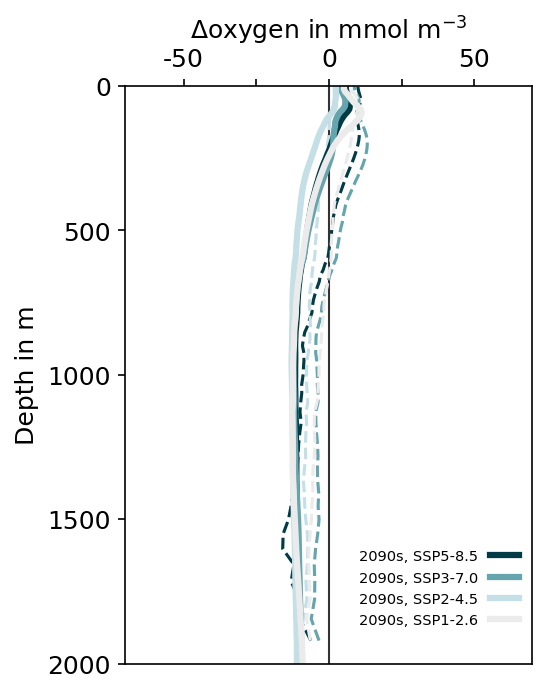

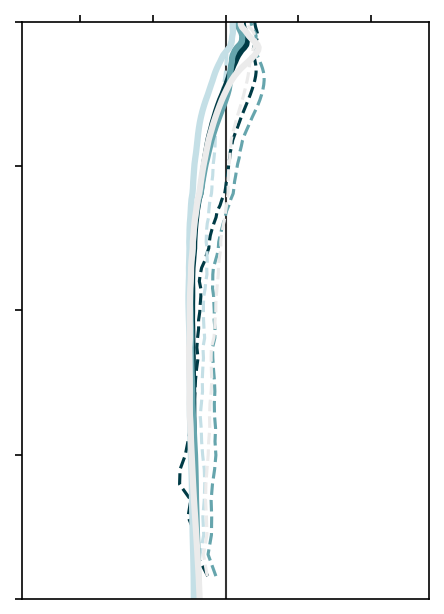

WeddellSea_MPA


/tmp/ipykernel_633410/4085224255.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:72: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/4085224255.py:78: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


WeddellSea_MPA_shelf


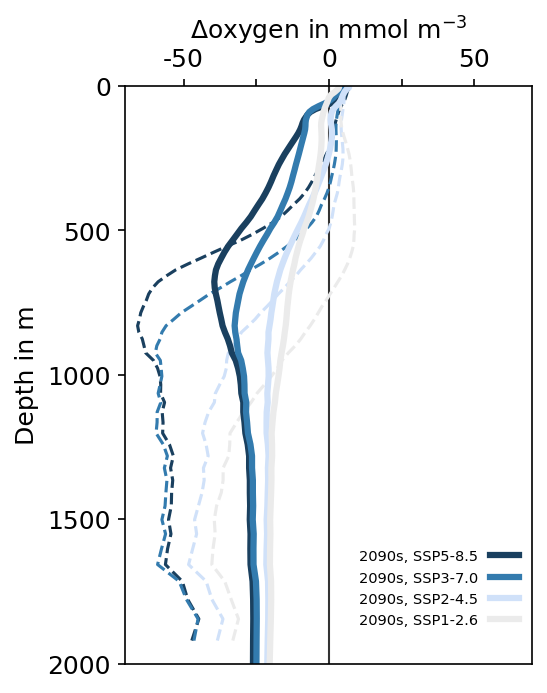

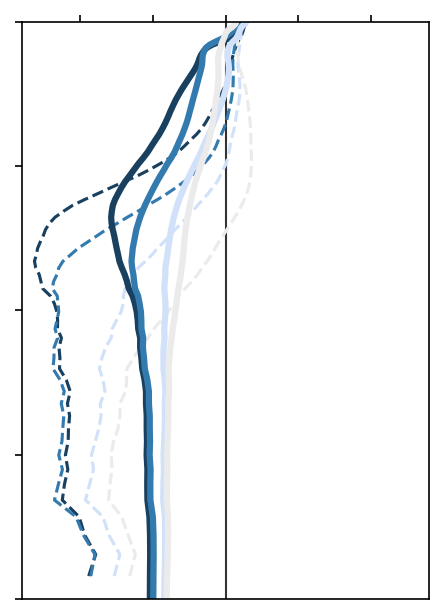

Orkney_MPA


/tmp/ipykernel_633410/4085224255.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])


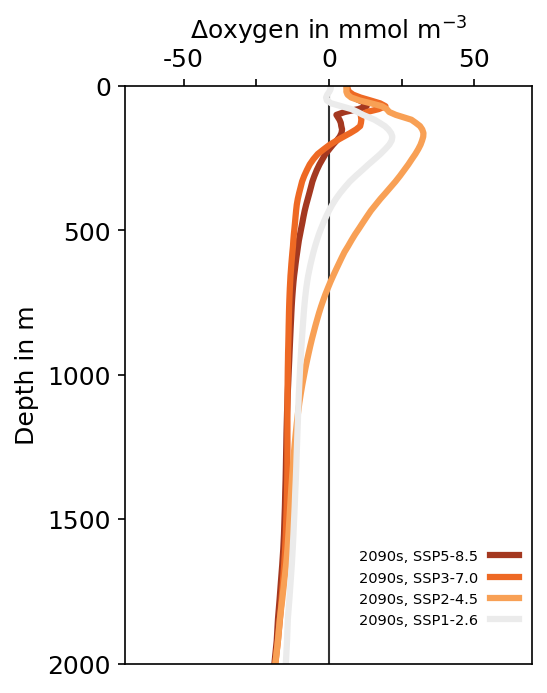

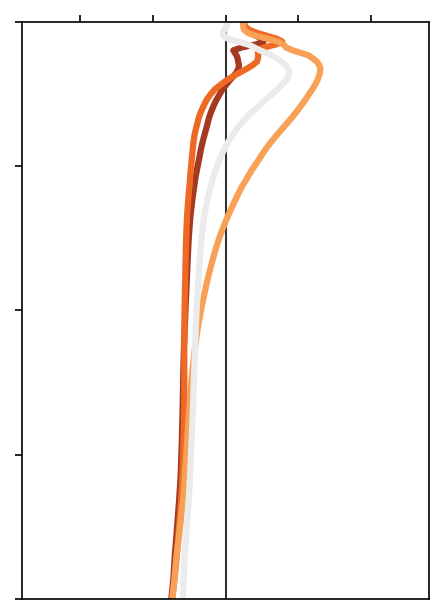

AntarcticPeninsula_MPA


/tmp/ipykernel_633410/4085224255.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:72: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/4085224255.py:78: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


AntarcticPeninsula_MPA_shelf


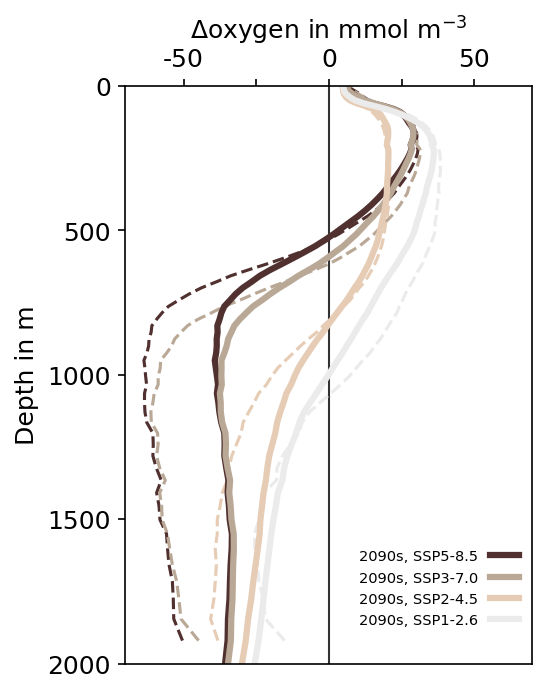

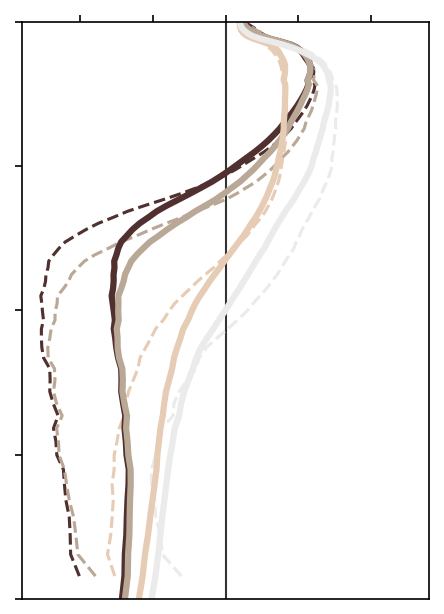

East_Antarctica_all_MPA


/tmp/ipykernel_633410/4085224255.py:50: RuntimeWarning: invalid value encountered in double_scalars
  profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:56: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])
/tmp/ipykernel_633410/4085224255.py:72: RuntimeWarning: invalid value encountered in double_scalars
  profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])
/tmp/ipykernel_633410/4085224255.py:78: RuntimeWarning: invalid value encountered in double_scalars
  profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])


East_Antarctica_all_MPA_shelf


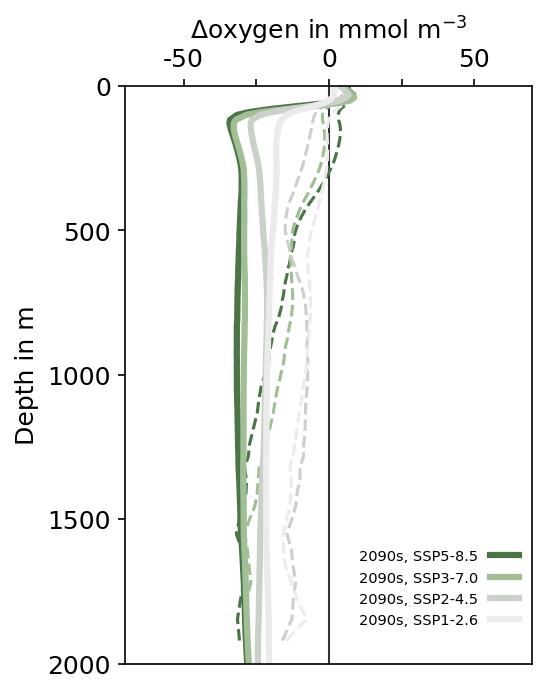

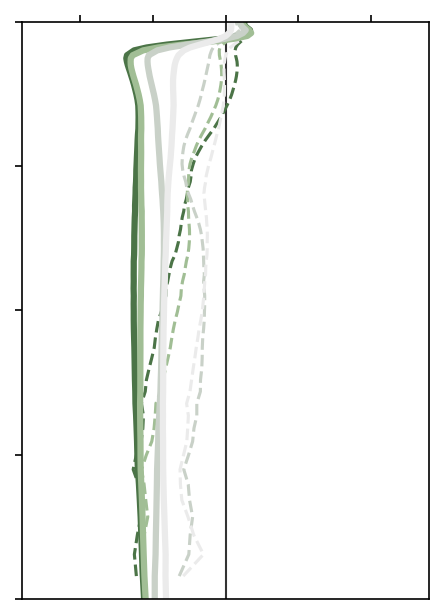

done


In [12]:
#----
# PLOT vertical profile of change in oxygen
#----

# available subregions (see function 'get_indices_in_region()')
subregions = ['all_shelves','WeddellSea','eWeddellSea','Prydz','Adelie','RossSea','Amundsen_Bellingshausen','WAP',\
             'RossSea_MPA','RossSea_MPA_shelf','RossSea_MPA_openOcean',\
              'WeddellSea_MPA','WeddellSea_MPA_shelf','WeddellSea_MPA_openOcean',\
              'Orkney_MPA','AntarcticPeninsula_MPA',\
             'East_Antarctica_1_MPA','East_Antarctica_2_MPA','East_Antarctica_3_MPA','East_Antarctica_all_MPA',\
             'East_Antarctica_1_MPA_shelf','East_Antarctica_2_MPA_shelf',\
              'East_Antarctica_3_MPA_shelf','East_Antarctica_all_MPA_shelf',\
             'East_Antarctica_1_MPA_openOcean','East_Antarctica_2_MPA_openOcean',\
              'East_Antarctica_3_MPA_openOcean','East_Antarctica_all_MPA_openOcean',\
             'AntarcticPeninsula_MPA_openOcean','AntarcticPeninsula_MPA_shelf']

save_plot = False
display_plots = True

for rr in [8,11,14,15,19]: # HARD-CODED
    print (subregions[rr])
    
    # get indices of original FESOM mesh that lie in current subregion
    ind1_so = get_indices_in_region(rr,subregions,path_to_mask)

    #-----
    # get avg vertical profiles
    #-----

    data1 = np.copy(array_1990s_simA)
    data2 = np.copy(array_2090s)

    area2 = np.copy(area)
    area2 = np.tile(area2,[data1.shape[0],1])
    
    num_depths = area2.shape[0]
    depths = np.unique(zlevs)#[:-2]

    #------
    # set zeros to NaN
    # make sure to also correct 
    # area field so that the "total area" at each depth level actually corresponds ot the area that is there
    area2[data1==0]=np.nan 
    data1[data1==0]=np.nan
    data2[data2==0]=np.nan
    #------
    
    # pH, 1990s
    profile_so = np.nan*np.zeros([area2.shape[0]])
    for dd in range(0,area2.shape[0]): # loop over depths
        profile_so[dd] = np.nansum(data1[dd,ind1_so]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])

    # pH, 2090s
    profile_2090s_so = np.nan*np.zeros([area2.shape[0],len(sim_list)])
    for ss in range(0,len(sim_list)):
        for dd in range(0,area2.shape[0]): # loop over depths
            profile_2090s_so[dd,ss] = np.nansum(data2[dd,ind1_so,ss]*area2[dd,ind1_so])/np.nansum(area2[dd,ind1_so])

            
    #-----
    # get corresponding shelf part
    #-----      
    if not subregions[rr] in ['Orkney_MPA']: 
        ind_shelf = subregions.index(subregions[rr]+'_shelf')
        print (subregions[ind_shelf])

        # get indices of original FESOM mesh that lie in current subregion
        ind1_so_b = get_indices_in_region(ind_shelf,subregions,path_to_mask)

        # omega arag, 1990s
        profile_so_shelf = np.nan*np.zeros([area2.shape[0]])
        for dd in range(0,area2.shape[0]): # loop over depths
            profile_so_shelf[dd] = np.nansum(data1[dd,ind1_so_b]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])

        # omega arag, 2090s
        profile_2090s_so_shelf = np.nan*np.zeros([area2.shape[0],len(sim_list)])
        for ss in range(0,len(sim_list)):
            for dd in range(0,area2.shape[0]): # loop over depths
                profile_2090s_so_shelf[dd,ss] = np.nansum(data2[dd,ind1_so_b,ss]*area2[dd,ind1_so_b])/np.nansum(area2[dd,ind1_so_b])

    else:
        profile_so_shelf         = np.nan*np.zeros([area2.shape[0]])
        profile_2090s_so_shelf   = np.nan*np.zeros([area2.shape[0],len(sim_list)])
        
            
    #---
    # plot, save as png
    #---
    format2 = 'png'
    
    vari_label = '$\Delta$oxygen in mmol m$^{-3}$'
    vari = 'oxygen'
    plot_profile_DEOXY_shelf_vs_whole_MPA_save_as_png_or_eps(profile_so,profile_2090s_so,\
                                    profile_so_shelf,profile_2090s_so_shelf,vari,vari_label,subregions,rr,\
                             num_depths,depths,save_plot,display_plots,savepath,format2)
     
    plot_eps = True
    if plot_eps:
        #---
        # plot, save as eps
        #---
        format2 = 'eps'

        vari_label = 'oxygen'
        vari = 'oxygen'
        plot_profile_DEOXY_shelf_vs_whole_MPA_save_as_png_or_eps(profile_so,profile_2090s_so,\
                                    profile_so_shelf,profile_2090s_so_shelf,vari,vari_label,subregions,rr,\
                                 num_depths,depths,save_plot,display_plots,savepath,format2)
    
print ('done')

In [ ]:
print (savepath)